In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(832366, 110)



# Triage Accuracy

(How many patients did they get right and do they do it in the right order, for example: still or obvious life threat first (Red, Gray, Black), then wavers, then walkers last.)


### Adjusted R-squared

I am using the adjusted R-squared value of a linear regression model fit as a measure of how well trainees engaged the still first, then wavers, then walkers last. A score of 1.0 will mean that the trainee performed the ideal sequence. A score of -1.0 means that the trainee performed the opposite sequence.

The algorithm will work for any number of patients. It allows for any number of still patients, which will be correctly placed in the beginning of the ideal sequence. The numbers are just the milliseconds of elapsed time at the engagement of a patient. The scenes are zero-indexed _SESSION_START_ to _SESSION_END_ segments. Time group 1 is the 2nd session in the file, for instance.

This is possibly also a measure of Tolerance for Risk (see https://nextcentury.atlassian.net/wiki/spaces/ITMC/pages/2998960129/KDMAs).

In [4]:

# Create a dataset of measures of right ordering
if nu.pickle_exists('engagment_sort_df'):
    engagment_sort_df = nu.load_object('engagment_sort_df')
else:
    import statsmodels.api as sm
    groupby_columns = ['session_uuid', 'time_group']
    gb = frvrs_logs_df.groupby(groupby_columns)
    rows_list = []
    for (session_uuid, time_group), df1 in gb:
        row_dict = {}
        
        # Add the logger version for the current group
        logger_version = df1.logger_version.unique().item()
        row_dict['logger_version'] = logger_version
        
        # Populate the row_dict with values from the groupby_columns
        for cn in groupby_columns: row_dict[cn] = eval(cn)
    
        # Get the last engagement time among all the obvious life threats
        assert ('tag_applied_type' in df1.columns)
        mask_series = df1.tag_applied_type.isin(['red', 'gray', 'black'])
        df = df1[mask_series]
        if df.shape[0]:
            # display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)
            patient_ids_list = df.patient_id.unique().tolist()
            mask_series = True
            for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
            mask_series &= frvrs_logs_df.patient_id.isin(patient_ids_list)
            mask_series &= (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
            row_dict['last_threat_engaged'] = frvrs_logs_df[mask_series].elapsed_time.max()
    
        # Group the patients by engagement SORT category and get lists of their elapsed times
        engaged_sort_dict = {}
        for patient_engaged_sort, df2 in df1.groupby('patient_engaged_sort'):
            if patient_engaged_sort in ['still', 'waver', 'walker']:
                patient_ids_list = df2.patient_id.unique().tolist()
                mask_series = True
                for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
                mask_series &= frvrs_logs_df.patient_id.isin(patient_ids_list)
                mask_series &= (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
                row_dict[f'last_{patient_engaged_sort}_engaged'] = frvrs_logs_df[mask_series].elapsed_time.max()
                engaged_sort_dict[patient_engaged_sort] = frvrs_logs_df[mask_series].sort_values(
                    ['elapsed_time']
                ).elapsed_time.tolist()
        
        # Get an R-squared Adjusted as a measure of right ordering
        # if (session_uuid == '7de52180-d823-4f9e-9003-aeab8139970b') and (time_group == 1): raise
        ideal_sequence = []
        for sort in ['still', 'waver', 'walker']: ideal_sequence.extend(engaged_sort_dict.get(sort, []))
        ideal_sequence = pd.Series(data=ideal_sequence)
        actual_sequence = ideal_sequence.sort_values(ascending=True)
        X, y = ideal_sequence.values.reshape(-1, 1), actual_sequence.values.reshape(-1, 1)
        if X.shape[0]:
            X1 = sm.add_constant(X)
            try: rsquared_adj = sm.OLS(y, X1).fit().rsquared_adj
            except: rsquared_adj = np.nan
            row_dict['rsquared_adj'] = rsquared_adj
        
        rows_list.append(row_dict)
    
    engagment_sort_df = DataFrame(rows_list)
    nu.store_objects(engagment_sort_df=engagment_sort_df)

In [5]:

# Display a sample of the data frame, dropping columns with all NaN values and transposing it
display(engagment_sort_df.sample(min(4, engagment_sort_df.shape[0])).dropna(axis='columns', how='all').T)

,917,653,1089,323
logger_version,1.3,1.0,1.3,1.0
session_uuid,daca96a3-b61d-4087-9747-cea6fd7e3a43,98bad4ce-f31e-40f1-898e-ed38755e0340,ff4c3532-5924-45b6-9a6a-d0d3274b6ef0,45118b95-412c-4a2d-9373-8f7da3428ca8
time_group,0,0,1,2
last_threat_engaged,NaN,NaN,NaN,742793.0
last_walker_engaged,NaN,NaN,39494.0,742793.0
rsquared_adj,NaN,NaN,NaN,0.658995
last_still_engaged,NaN,NaN,NaN,673504.0
last_waver_engaged,NaN,NaN,NaN,580506.0
stills_finished_first,NaN,NaN,NaN,False



Here is a histogram of the values:

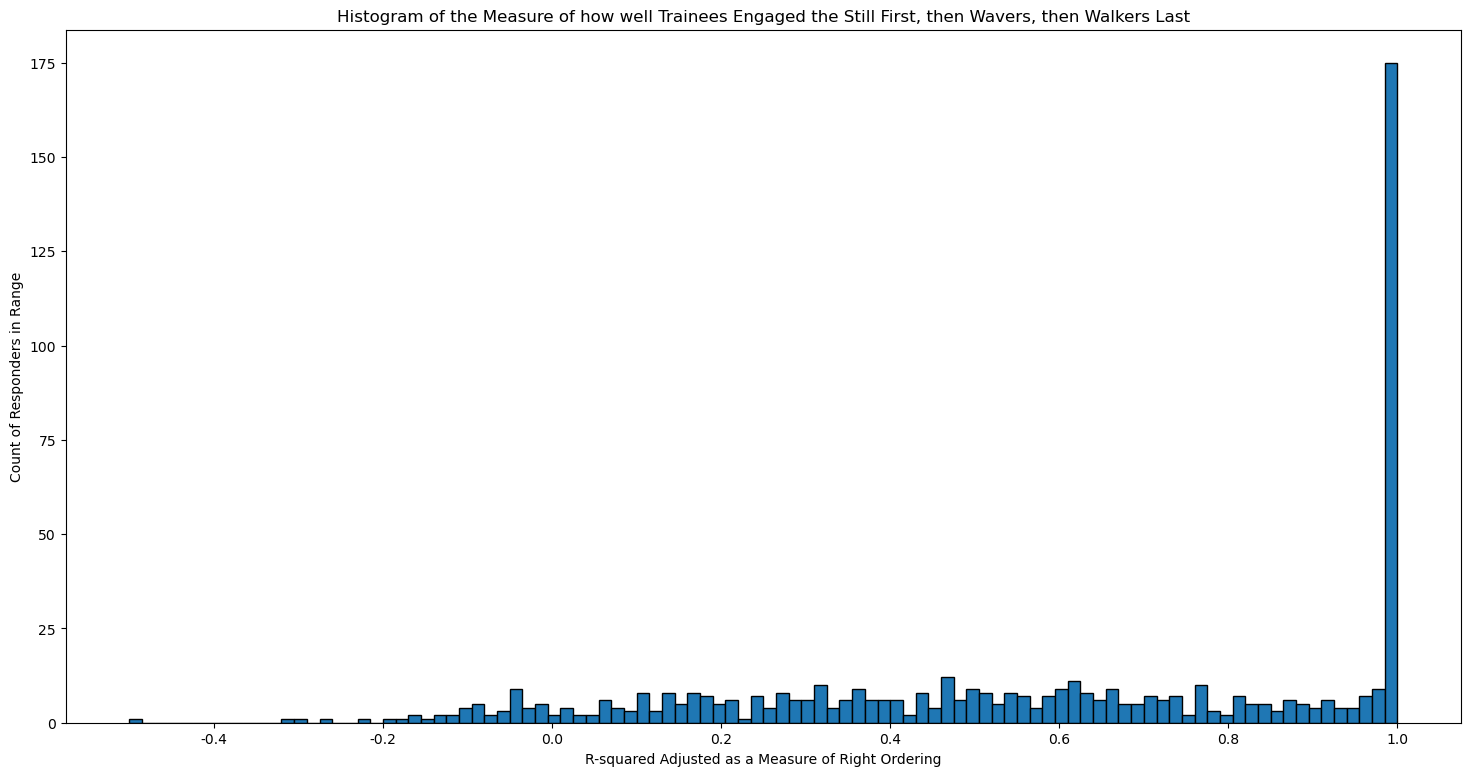

In [6]:

# Display a histogram of the distribution of the measure of
# how well trainees engaged the still first, then wavers, then walkers last
xlabel = 'R-squared Adjusted as a Measure of Right Ordering'
get_xtick_text = lambda text_obj: round(text_obj.get_position()[0], 2)
title = 'Histogram of the Measure of how well Trainees Engaged the Still First, then Wavers, then Walkers Last'
ylabel = 'Count of Responders in Range'
ax = nu.plot_histogram(engagment_sort_df, 'rsquared_adj', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=False)

In [7]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
columns_list = [
    'rsquared_adj'
]
df = engagment_sort_df[columns_list]
display(nu.get_statistics(columns_list, df).applymap(lambda x: round(x, 1), na_action='ignore').T)

,mean,mode,median,SD,min,25%,50%,75%,max
rsquared_adj,0.6,1.0,0.6,0.4,-0.5,0.3,0.6,1.0,1.0



## How many responders did the right order? Should be a percentage of all responders


In [8]:

total_count = engagment_sort_df.shape[0]
mask_series = (engagment_sort_df.rsquared_adj == 1.0)
correct_count = engagment_sort_df[mask_series].shape[0]
percentage_tag_correct = 100*correct_count/total_count
print(f'{percentage_tag_correct:.2f}% of all responders engaged the still first, then wavers, then walkers last, in an ideal sequence.')

15.04% of all responders engaged the still first, then wavers, then walkers last, in an ideal sequence.



## Did they get the correct tag applied?

In [9]:

# Investigate the columns of severity
# print([cn for cn in one_hot_encode_df.columns if 'sever' in cn])
print([cn for cn in frvrs_logs_df.columns if 'sever' in cn.lower()])
# print([cn for cn in patient_history_df.columns if 'sever' in cn])

['injury_record_severity', 'injury_treated_severity']


In [10]:

# Investigate the presence of breathing
# srs = frvrs_logs_df.applymap(lambda x: 'breath' in str(x).lower(), na_action='ignore').sum()
# columns_list = srs[srs != 0].index.tolist()
# if columns_list: print(columns_list)
print([cn for cn in frvrs_logs_df.columns if 'breath' in cn.lower()])
print(frvrs_logs_df.patient_record_breath.unique().tolist())

['patient_demoted_breath', 'patient_record_breath', 'patient_engaged_breath']
[nan, 'normal', 'collapsedRight', 'none', 'restricted', 'fast']


In [11]:

# Investigate the presence of response
# srs = frvrs_logs_df.applymap(lambda x: 'respons' in str(x).lower(), na_action='ignore').sum()
# columns_list = srs[srs != 0].index.tolist()
# if columns_list: print(columns_list)
# print([cn for cn in frvrs_logs_df.columns if 'respons' in cn.lower()])
print(frvrs_logs_df.patient_record_mood.unique().tolist())

[nan, 'upset', 'unresponsive', 'dead', 'agony', 'calm']


In [12]:

frvrs_logs_df.injury_record_severity.unique()

array([nan, 'low', 'medium', 'high'], dtype=object)


## How many patients did they get right? Should be percentage per responders



<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/salt_mass_casualty_triage.png" />

In [13]:

print(frvrs_logs_df.tag_applied_type.unique().tolist())
print(frvrs_logs_df.patient_record_salt.unique().tolist())
salt_to_tag_dict = {'DEAD': 'black', 'EXPECTANT': 'gray', 'IMMEDIATE': 'red', 'DELAYED': 'yellow', 'MINIMAL': 'green'}

[nan, 'red', 'yellow', 'green', 'black', 'gray']
[nan, 'MINIMAL', 'DELAYED', 'IMMEDIATE', 'DEAD', 'EXPECTANT']


In [14]:

# Initialize (if necessary) an empty data frame to store injury severity data and iterate over the patient groups
if nu.pickle_exists('tag_to_salt_df'): tag_to_salt_df = nu.load_object('tag_to_salt_df')
else:
    
    # Iterate through each patient, run, and session
    groupby_columns = ['session_uuid', 'time_group', 'patient_id']
    gb = frvrs_logs_df.sort_values(['elapsed_time']).groupby(groupby_columns)
    rows_list = []
    for (session_uuid, time_group, patient_id), df in gb:
        
        # Add the logger version and the groupby columns to the row dictionary
        row_dict = {}
        row_dict['logger_version'] = df.logger_version.unique().item()
        for cn in groupby_columns: row_dict[cn] = eval(cn)
        row_dict['patient_count'] = 1

        # Get non-null tag applied types and patient record SALTs
        mask_series = ~df.tag_applied_type.isnull() | ~df.patient_record_salt.isnull()
        df1 = df[mask_series]

        # Add the last tag value
        mask_series = df1.tag_applied_type.isnull()
        try: last_tag = df1[~mask_series].tag_applied_type.tolist()[-1]
        except Exception: last_tag = np.nan
        row_dict['last_tag'] = last_tag

        # Add the max salt value
        mask_series = df1.patient_record_salt.isnull()
        try: max_salt = df1[~mask_series].patient_record_salt.max()
        except Exception: max_salt = np.nan
        row_dict['max_salt'] = max_salt

        # Add the predicted tag value
        try: predicted_tag = salt_to_tag_dict.get(row_dict['max_salt'], np.nan)
        except Exception: predicted_tag = np.nan
        row_dict['predicted_tag'] = predicted_tag

        # Add if tag is correct
        try: is_tag_correct = bool(last_tag == predicted_tag)
        except Exception: is_tag_correct = np.nan
        row_dict['is_tag_correct'] = is_tag_correct

        # Add the row dictionary to the list
        rows_list.append(row_dict)
    
    # Store the patient history data frame
    tag_to_salt_df = pd.DataFrame(rows_list)
    nu.store_objects(tag_to_salt_df=tag_to_salt_df, verbose=True)

In [15]:

nu.get_minority_combinations(tag_to_salt_df, ['last_tag', 'predicted_tag']).dropna(axis='columns', how='all').T

,733,8751,8681,6721
logger_version,1.3,1.0,1.3,1.3
session_uuid,0fa439d6-476c-49a5-b478-48e3454974e1,e353eee2-a630-40cd-b931-a98b12edd9b6,e249e6d4-c3d4-4e20-8fab-fa35fd59e871,aec5d448-c4e6-4af7-8e36-d258c7bb6f96
time_group,2,1,1,1
patient_id,Gary_1 Root,Bob_0 Root,Gary_1 Root,Gary_0 Root
patient_count,1,1,1,1
last_tag,yellow,red,green,black
max_salt,EXPECTANT,DEAD,EXPECTANT,MINIMAL
predicted_tag,gray,black,gray,green
is_tag_correct,False,False,False,False


In [28]:

mask_series = tag_to_salt_df.last_tag.isnull() | tag_to_salt_df.max_salt.isnull()
df = tag_to_salt_df[mask_series]
print(df.shape)
display(df.sample(min(5, df.shape[0])).dropna(axis='columns', how='all').T)

(4938, 9)


,598,7404,8961,1165,696
logger_version,1.0,1.3,1.0,1.3,1.3
session_uuid,0b891add-e0c3-463d-948d-7f491f1d10ef,c74476ed-d5ee-4318-86e0-fefebe5e32ee,e8cb6ae0-6d68-410f-88fc-4adf30d8bfac,17b80e0f-9afe-497f-b3a3-0549c14a4ba9,0dc94285-ba14-40aa-9745-76504502a5cc
time_group,3,0,3,0,2
patient_id,Lily_0 Root,Mike_9 Root,Lily_0 Root,Bob_0 Root,Bob_9 Root
patient_count,1,1,1,1,1
max_salt,NaN,NaN,DEAD,NaN,MINIMAL
predicted_tag,NaN,NaN,black,NaN,green
is_tag_correct,False,False,False,False,False


In [16]:

mask_series = tag_to_salt_df.is_tag_correct.isnull()
tag_to_salt_df[mask_series].sample(min(5, tag_to_salt_df[mask_series].shape[0])).dropna(axis='columns', how='all').T

""


In [17]:

# Get the total and correct counts for each run
rows_list = []
groupby_columns = ['session_uuid', 'time_group']
for (session_uuid, time_group), df in tag_to_salt_df.groupby(groupby_columns):
    
    # Add the logger version and the groupby columns to the row dictionary
    row_dict = {}
    row_dict['logger_version'] = df.logger_version.unique().item()
    for cn in groupby_columns: row_dict[cn] = eval(cn)

    # Add the total and correct counts for this run
    mask_series = (df.is_tag_correct == True)
    correct_count = df[mask_series].patient_count.sum()
    row_dict['correct_count'] = correct_count
    total_count = df.patient_count.sum()
    row_dict['total_count'] = total_count
    
    # Add percentage that tag is correct
    try: percentage_tag_correct = 100*correct_count/total_count
    except Exception: percentage_tag_correct = np.nan
    row_dict['percentage_tag_correct'] = percentage_tag_correct
    
    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Create the correct count data frame
correct_count_df = pd.DataFrame(rows_list)

In [18]:

correct_count_df

,logger_version,session_uuid,time_group,correct_count,total_count,percentage_tag_correct
0,1.3,009b848c-ea64-4f22-bd40-711213a3d327,1,0,10,0.000000
1,1.3,009b848c-ea64-4f22-bd40-711213a3d327,2,7,11,63.636364
2,1.0,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655,0,0,3,0.000000
3,1.0,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655,1,3,12,25.000000
4,1.0,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655,2,9,11,81.818182
...,...,...,...,...,...,...
1063,1.0,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,1,4,12,33.333333
1064,1.0,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,2,11,11,100.000000
1065,1.3,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,0,4,0.000000
1066,1.3,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,1,3,12,25.000000


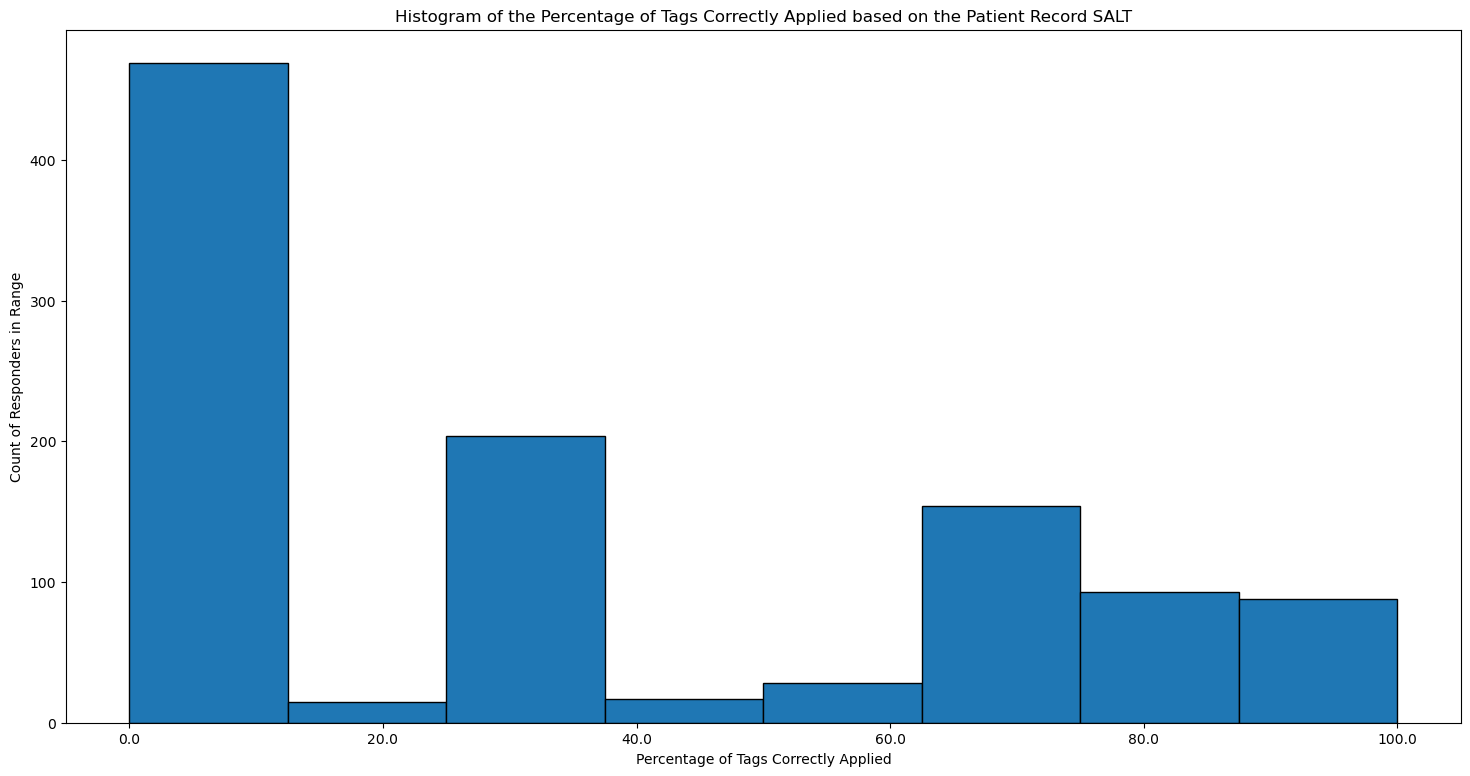

In [19]:

# Display a histogram of the percentage of tags correctly applied based on the patient record SALT
xlabel = 'Percentage of Tags Correctly Applied'
get_xtick_text = lambda text_obj: round(text_obj.get_position()[0], 2)
title = 'Histogram of the Percentage of Tags Correctly Applied based on the Patient Record SALT'
ylabel = 'Count of Responders in Range'
ax = nu.plot_histogram(correct_count_df, 'percentage_tag_correct', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=False, bins=8)

In [20]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
columns_list = [
    'correct_count', 'total_count', 'percentage_tag_correct'
]
df = correct_count_df[columns_list]
display(nu.get_statistics(columns_list, df).applymap(lambda x: round(x, 2), na_action='ignore').T)

,mean,mode,median,SD,min,25%,50%,75%,max
correct_count,3.72,0.0,4.00,3.80,0.0,0.0,4.00,8.00,13.0
total_count,9.25,11.0,11.00,3.52,1.0,8.0,11.00,11.00,26.0
percentage_tag_correct,33.37,0.0,33.33,34.52,0.0,0.0,33.33,67.86,100.0



### Break down accuracy for each responder by tag


In [31]:

tag_to_salt_df.predicted_tag.unique()

array([nan, 'green', 'black', 'gray', 'red', 'yellow'], dtype=object)

In [34]:

# Get the total and correct counts for each run for each tag
rows_list = []
tagged_mask_series = tag_to_salt_df.last_tag.isnull() | tag_to_salt_df.max_salt.isnull()

# Add the normal section
groupby_columns = ['session_uuid', 'time_group', 'predicted_tag']
for (session_uuid, time_group, predicted_tag), df in tag_to_salt_df[~tagged_mask_series].groupby(groupby_columns):
    
    # Add the logger version and the groupby columns to the row dictionary
    row_dict = {}
    row_dict['logger_version'] = df.logger_version.unique().item()
    for cn in groupby_columns: row_dict[cn] = eval(cn)

    # Add the total and correct counts for this run
    mask_series = (df.is_tag_correct == True)
    correct_count = df[mask_series].patient_count.sum()
    row_dict['correct_count'] = correct_count
    total_count = df.patient_count.sum()
    row_dict['total_count'] = total_count
    
    # Add percentage that tag is correct
    try: percentage_tag_correct = 100*correct_count/total_count
    except Exception: percentage_tag_correct = np.nan
    row_dict['percentage_tag_correct'] = percentage_tag_correct
    
    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Add the not-tagged section
groupby_columns = ['session_uuid', 'time_group']
for (session_uuid, time_group), df in tag_to_salt_df[tagged_mask_series].groupby(groupby_columns):
    
    # Add the logger version and the groupby columns to the row dictionary
    row_dict = {}
    row_dict['logger_version'] = df.logger_version.unique().item()
    for cn in groupby_columns: row_dict[cn] = eval(cn)
    row_dict['predicted_tag'] = 'Not Tagged'

    # Add the total and correct counts for this run
    mask_series = (df.is_tag_correct == True)
    correct_count = df[mask_series].patient_count.sum()
    row_dict['correct_count'] = correct_count
    total_count = df.patient_count.sum()
    row_dict['total_count'] = total_count
    
    # Add percentage that tag is correct
    try: percentage_tag_correct = 100*correct_count/total_count
    except Exception: percentage_tag_correct = np.nan
    row_dict['percentage_tag_correct'] = percentage_tag_correct
    
    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Create the correct count data frame
correct_count_by_tag_df = pd.DataFrame(rows_list)

In [37]:

correct_count_by_tag_df

,logger_version,session_uuid,time_group,predicted_tag,correct_count,total_count,percentage_tag_correct
0,1.3,009b848c-ea64-4f22-bd40-711213a3d327,1,green,0,1,0.0
1,1.3,009b848c-ea64-4f22-bd40-711213a3d327,2,black,0,1,0.0
2,1.3,009b848c-ea64-4f22-bd40-711213a3d327,2,gray,1,1,100.0
3,1.3,009b848c-ea64-4f22-bd40-711213a3d327,2,green,2,2,100.0
4,1.3,009b848c-ea64-4f22-bd40-711213a3d327,2,red,3,4,75.0
...,...,...,...,...,...,...,...
3308,1.3,ff4c3532-5924-45b6-9a6a-d0d3274b6ef0,2,Not Tagged,0,1,0.0
3309,1.0,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,0,Not Tagged,0,4,0.0
3310,1.0,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,1,Not Tagged,0,8,0.0
3311,1.3,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,Not Tagged,0,4,0.0


In [38]:

mask_series = correct_count_by_tag_df.predicted_tag.isnull()
df = correct_count_by_tag_df[mask_series]
print(df.shape)
display(df.sample(min(5, df.shape[0])).dropna(axis='columns', how='all').T)

(0, 7)


""


,mean,mode,median,SD,min,25%,50%,75%,max
correct_green_tag_count,1.71,1.0,2.0,0.97,0.0,1.00,2.0,3.0,4.0
total_green_tag_count,2.15,3.0,2.0,1.03,1.0,1.00,2.0,3.0,4.0
percentage_green_tag_correct,80.99,100.0,100.0,30.55,0.0,66.67,100.0,100.0,100.0


,mean,mode,median,SD,min,25%,50%,75%,max
correct_black_tag_count,0.97,1.0,1.0,0.17,0.0,1.0,1.0,1.0,1.0
total_black_tag_count,1.00,1.0,1.0,0.00,1.0,1.0,1.0,1.0,1.0
percentage_black_tag_correct,97.13,100.0,100.0,16.72,0.0,100.0,100.0,100.0,100.0


,mean,mode,median,SD,min,25%,50%,75%,max
correct_gray_tag_count,0.70,1.0,1.0,0.46,0.0,0.0,1.0,1.0,1.0
total_gray_tag_count,1.00,1.0,1.0,0.00,1.0,1.0,1.0,1.0,1.0
percentage_gray_tag_correct,70.35,100.0,100.0,45.74,0.0,0.0,100.0,100.0,100.0


,mean,mode,median,SD,min,25%,50%,75%,max
correct_red_tag_count,2.61,2.0,2.0,1.13,0.0,2.0,2.0,4.0,6.0
total_red_tag_count,3.21,4.0,4.0,1.15,1.0,2.0,4.0,4.0,9.0
percentage_red_tag_correct,83.58,100.0,100.0,24.47,0.0,75.0,100.0,100.0,100.0


,mean,mode,median,SD,min,25%,50%,75%,max
correct_yellow_tag_count,1.25,1.0,1.0,0.69,0.0,1.0,1.0,2.0,3.0
total_yellow_tag_count,1.61,2.0,2.0,0.61,1.0,1.0,2.0,2.0,3.0
percentage_yellow_tag_correct,78.80,100.0,100.0,35.37,0.0,50.0,100.0,100.0,100.0


,mean,mode,median,SD,min,25%,50%,75%,max
correct_not_tagged_tag_count,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
total_not_tagged_tag_count,6.31,8.0,8.0,3.39,1.0,3.0,8.0,8.0,25.0
percentage_not_tagged_tag_correct,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


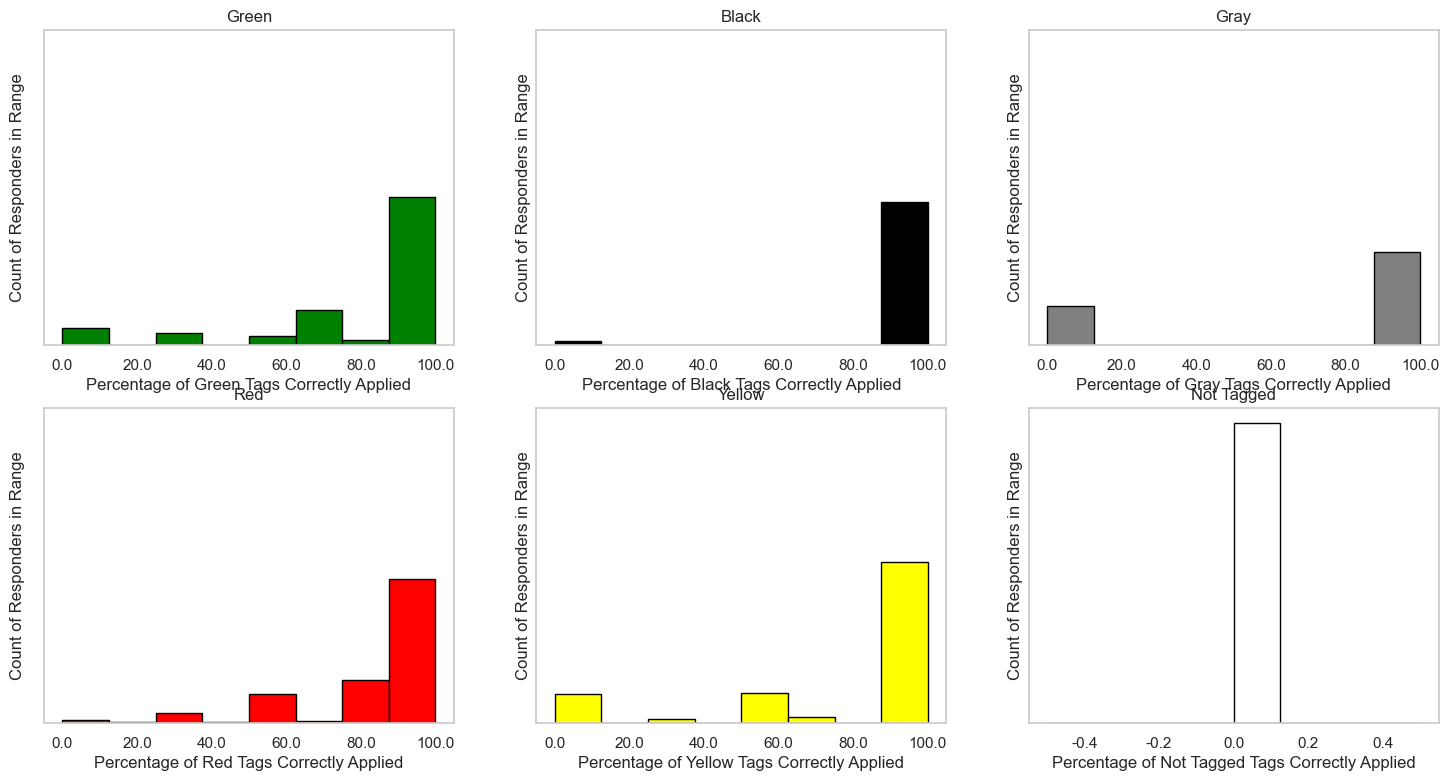

In [51]:

# Display a histogram of the percentage of tags correctly applied based on the patient record SALT, separated by tag
import numpy as np

get_xtick_text = lambda text_obj: round(text_obj.get_position()[0], 2)
ylabel = 'Count of Responders in Range'

# Calculate the number of plots and the number of rows and columns
unique_tags = correct_count_by_tag_df.predicted_tag.unique()
num_plots = len(unique_tags)
num_rows = min(num_plots, 2)
num_cols = int(np.ceil(num_plots / num_rows))

# Create a figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 9), sharex=False, sharey=True)
columns_list = [
    'correct_count', 'total_count', 'percentage_tag_correct'
]
for i, predicted_tag in enumerate(unique_tags):
    
    # Get the histogram data
    mask_series = (correct_count_by_tag_df.predicted_tag == predicted_tag)
    xlabel = f'Percentage of {predicted_tag.title()} Tags Correctly Applied'
    color = 'white' if (predicted_tag == 'Not Tagged') else predicted_tag.lower()
    ax = nu.plot_histogram(
        correct_count_by_tag_df[mask_series], 'percentage_tag_correct', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=predicted_tag.title(), ylabel=ylabel, xticks_are_temporal=False,
        ax=axs[i // num_cols, i % num_cols], color=color, bins=8
    )
    
    axs[i // num_cols, i % num_cols].grid(False)
    
    # Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
    renamed_columns_list = [
        f'correct_{predicted_tag}_tag_count', f'total_{predicted_tag}_tag_count', f'percentage_{predicted_tag}_tag_correct'
    ]
    renamed_columns_list = [cn.lower().replace(' ', '_') for cn in renamed_columns_list]
    df = correct_count_by_tag_df[mask_series][columns_list].rename(columns={k: v for k, v in zip(columns_list, renamed_columns_list)})
    display(nu.get_statistics(renamed_columns_list, df).applymap(lambda x: round(x, 2), na_action='ignore').T)

# Remove the remainder of the plots
i += 1
while i < (num_rows * num_cols):
    axs[i // num_cols, i % num_cols].remove()
    i += 1

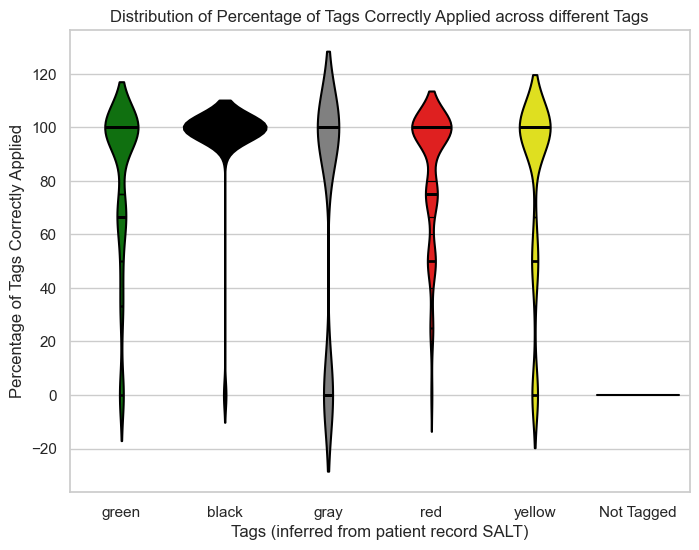

In [48]:

import seaborn as sns

# Sample data for the violin plot
data = {
    'predicted_tag': correct_count_by_tag_df.predicted_tag.tolist(),
    'percentage_tag_correct': correct_count_by_tag_df.percentage_tag_correct.tolist()
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set the style of the plot
sns.set(style='whitegrid')

# Create the violin plot with 5 violins
plt.figure(figsize=(8, 6))
palette = ['white' if (color == 'Not Tagged') else color for color in unique_tags]
sns.violinplot(x='predicted_tag', y='percentage_tag_correct', data=df, palette=palette, inner='stick')

# Set plot labels and title
plt.xlabel('Tags (inferred from patient record SALT)')
plt.ylabel('Percentage of Tags Correctly Applied')
plt.title('Distribution of Percentage of Tags Correctly Applied across different Tags')

# Show the plot
plt.show()


## How many responders correctly tagged all patients? Should be a percentage of all responders

In [44]:

total_count = correct_count_df.total_count.sum()
correct_count = correct_count_df.correct_count.sum()
percentage_tag_correct = 100*correct_count/total_count
print(f'{percentage_tag_correct:.2f}% of all responders correctly tagged all patients.')

40.19% of all responders correctly tagged all patients.




## Did they get it right?


### Build a model to predict *tag_applied_type*

In [9]:

# Display a sample of the data frame, dropping columns with all NaN values and transposing it
# display(frvrs_logs_df[mask_series].sample(min(4, frvrs_logs_df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

# Get the supervised learning and group by columns
input_features = [
    'patient_record_salt', 'patient_record_sort', 'patient_record_pulse', 'patient_record_breath', 'patient_record_hearing', 'patient_record_mood',
    'patient_record_pose', 'injury_record_id', 'injury_record_required_procedure', 'injury_record_severity', 'injury_record_body_region',
    'injury_record_injury_treated', 'injury_record_injury_treated_with_wrong_treatment', 'pulse_taken_pulse_name', 'patient_engaged_salt',
    'patient_engaged_sort', 'patient_engaged_pulse', 'patient_engaged_breath', 'patient_engaged_hearing', 'patient_engaged_mood', 'patient_engaged_pose',
    'injury_treated_id', 'injury_treated_required_procedure', 'injury_treated_severity', 'injury_treated_body_region', 'injury_treated_injury_treated',
    'injury_treated_injury_treated_with_wrong_treatment', 'tool_applied_type', 'tool_applied_attachment_point', 'tool_applied_tool_location',
    'tool_applied_data', 'tool_applied_sender'
    ]
target_variable = 'tag_applied_type'
groupby_columns = ['session_uuid', 'time_group', 'patient_id']

def one_hot_encode(df, columns):
    '''
    One-hot encodes the given columns in the given DataFrame.
    
    Args:
        df: A DataFrame.
        columns: A list of column names to encode.
    
    Returns:
        A DataFrame with the encoded columns.
    '''
    
    dummies = pd.get_dummies(df[columns], dummy_na=True)
    df = pd.concat([df, dummies], axis='columns').drop(columns, axis='columns')
    
    return df


#### Create a data frame with all the feature columns

In [10]:

# Initialize (if necessary) an empty data frame to store patient history data and iterate over the patient groups
if nu.pickle_exists('patient_history_df'): patient_history_df = nu.load_object('patient_history_df')
else:
    patient_history_df = pd.DataFrame([], columns=renamed_columns_list)
    
    # Keep track of the target variable and input features columns and the input features columns prepended with each of the action types
    columns_list = [target_variable] + input_features
    renamed_columns_list = [target_variable] + [action_type.lower() + '_' + cn for cn in input_features for action_type in frvrs_logs_df.action_type.unique()]
    
    # Group each patient, run, and session with non-null tag applied types
    tag_mask_series = ~frvrs_logs_df.tag_applied_type.isnull()
    gb = frvrs_logs_df[tag_mask_series].sort_values(['elapsed_time']).groupby(groupby_columns)
    
    from tqdm import tqdm
    for (session_uuid, time_group, patient_id), df1 in tqdm(gb, total=gb.size().shape[0]):
        
        # Create a mask for the specific patient
        patient_mask_series = True
        for cn in groupby_columns: patient_mask_series &= (frvrs_logs_df[cn] == eval(cn))
    
        # Create a mask for the patient's entire history, excluding the rows with applied tag types
        mask_series = ~tag_mask_series & patient_mask_series
    
        # If the patient's history is empty, create a new data frame with the patient's data
        if not patient_history_df[mask_series].shape[0]:
    
            # Expand the data frame to the patient's entire history
            df1 = frvrs_logs_df[patient_mask_series].sort_values('elapsed_time')
            
            # Initialize an empty DataFrame for each action type and loop over the action type groups
            action_type_df = pd.DataFrame([], columns=renamed_columns_list)
            gb1 = df1.groupby('action_type')
            for action_type, df in gb1:
                
                # Rename the columns of the data frame to match the desired format and fill in any missing values using the forward fill and backward fill methods
                df = df[columns_list].rename(columns={cn: action_type.lower() + '_' + cn for cn in input_features}).fillna(method='ffill').fillna(method='bfill')
    
                # Concatenate the data frame to the action_type_df data frame
                action_type_df = pd.concat([action_type_df, df], axis='index')
            
            # Rename the columns of the action type data frame to match the desired format, and fill in any missing values using the forward fill and backward fill methods
            df = action_type_df[renamed_columns_list].fillna(method='ffill').fillna(method='bfill')
    
            # Concatenate the data frame to the patient history data frame
            patient_history_df = pd.concat([patient_history_df, df], axis='index')
    
    # Store the patient history data frame
    nu.store_objects(patient_history_df=patient_history_df, verbose=False)

In [11]:

print(patient_history_df.shape)
# sorted(patient_history_df.columns)

(129867, 833)


In [12]:

df = patient_history_df.sample(min(4, patient_history_df.shape[0])).dropna(axis='columns', how='all').T
display(df.sample(min(20, df.shape[0])).sort_index())

,82414,317618,620826,795079
injury_record_injury_record_body_region,chest,leftArm,rightLeg,abdomen
injury_record_injury_record_injury_treated,False,False,False,False
injury_record_injury_record_injury_treated_with_wrong_treatment,False,False,False,False
injury_record_injury_record_required_procedure,woundpack,gauzePressure,tourniquet,woundpack
injury_record_injury_record_severity,medium,low,high,medium
injury_treated_injury_treated_injury_treated,True,NaN,True,True
injury_treated_injury_treated_severity,medium,NaN,high,medium
patient_engaged_patient_engaged_breath,normal,normal,fast,normal
patient_engaged_patient_engaged_hearing,normal,normal,normal,normal
patient_engaged_patient_engaged_pulse,fast,normal,fast,fast



#### One-hot encode it

In [13]:

# One-hot encode the input features columns in the one-hot encode data frame
if nu.pickle_exists('one_hot_encode_df'): one_hot_encode_df = nu.load_object('one_hot_encode_df')
else:
    ascii_regex = re.compile('[^a-z0-9]+')
    one_hot_encode_df = one_hot_encode(patient_history_df, [action_type.lower() + '_' + cn for cn in input_features for action_type in frvrs_logs_df.action_type.unique()])
    one_hot_encode_df = one_hot_encode_df.rename(columns={cn: ascii_regex.sub('_', cn.lower()).strip('_') for cn in one_hot_encode_df.columns})
    columns_list = [cn for cn in one_hot_encode_df.columns if any(map(lambda x: cn.endswith(x), ['_null', '_nan']))]
    
    # Store the patient history data frame
    nu.store_objects(one_hot_encode_df=one_hot_encode_df, verbose=False)
    
# print(columns_list)
df = one_hot_encode_df.sample(min(4, one_hot_encode_df.shape[0])).dropna(axis='columns', how='all').T
display(df.sample(min(20, df.shape[0])).sort_index())

,257508,332065,775681,756861
injury_record_injury_record_id_l_stomach_puncture,0,0,0,0
injury_record_tool_applied_type_nan,1,1,1,1
injury_treated_injury_treated_body_region_abdomen,0,1,0,0
injury_treated_injury_treated_id_r_chest_collapse,0,0,0,0
injury_treated_injury_treated_injury_treated_with_wrong_treatment_true,1,1,0,1
patient_demoted_patient_record_mood_nan,1,1,1,1
player_gaze_tool_applied_type_nan,1,1,1,1
s_a_l_t_walk_if_can_injury_record_id_nan,1,1,1,1
s_a_l_t_walk_if_can_injury_record_severity_nan,1,1,1,1
s_a_l_t_walk_if_can_patient_engaged_pose_nan,1,1,1,1


In [14]:

one_hot_encode_df.shape, one_hot_encode_df.dropna(axis='index', how='any').shape

((129867, 1025), (129867, 1025))

In [15]:

# Analyze the input features
if nu.pickle_exists('one_hot_column_descriptions_df'): one_hot_column_descriptions_df = nu.load_object('one_hot_column_descriptions_df')
else:
    one_hot_column_descriptions_df = nu.get_column_descriptions(one_hot_encode_df.sample(min(20, one_hot_encode_df.shape[0])))
    # mask_series = one_hot_column_descriptions_df.min_salt.isnull()
    
    # Store the column description data frame
    nu.store_objects(one_hot_column_descriptions_df=one_hot_column_descriptions_df, verbose=False)
    
display(one_hot_column_descriptions_df.sample(min(20, one_hot_column_descriptions_df.shape[0])).sort_index())

,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
41,s_a_l_t_walked_patient_record_sort_nan,uint8,0,1,0,True,1,1,True
142,tag_selected_patient_record_hearing_nan,uint8,0,1,0,True,1,1,True
197,bag_access_patient_record_pose_nan,uint8,0,1,0,True,1,1,True
243,injury_record_injury_record_id_r_thigh_laceration,uint8,0,2,19,True,0,1,True
266,patient_demoted_injury_record_required_procedu...,uint8,0,1,0,True,1,1,True
311,teleport_injury_record_severity_nan,uint8,0,1,0,True,1,1,True
356,tool_discarded_injury_record_body_region_nan,uint8,0,1,0,True,1,1,True
363,voice_command_injury_record_injury_treated_nan,uint8,0,1,0,True,1,1,True
380,tag_selected_injury_record_injury_treated_nan,uint8,0,1,0,True,1,1,True
426,bag_access_pulse_taken_pulse_name_nan,uint8,0,1,0,True,1,1,True



#### Train a classifier on it

In [16]:

# Train a classifier on the patient history data frame
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into training and test sets
df = one_hot_encode_df.dropna(axis='index', how='any')
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('tag_applied_type', axis='columns'),
    df.tag_applied_type,
    test_size=0.25,
    random_state=42
)

# Convert the uint8 features to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [17]:

# Create a random forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = rf_classifier.predict(X_test)
rf_accuracy = np.mean(y_pred == y_test)

# Calculate the feature importances
feature_importances = rf_classifier.feature_importances_

# Create a data frame to store the feature names and feature importances
if nu.pickle_exists('feature_importances_df'): feature_importances_df = nu.load_object('feature_importances_df')
else:
    feature_importances_df = pd.DataFrame()
    feature_importances_df['feature_name'] = df.drop('tag_applied_type', axis='columns').columns
    feature_importances_df['feature_importance'] = feature_importances
    
    # Store the feature importances data frame
    nu.store_objects(feature_importances_df=feature_importances_df, verbose=True)

In [18]:

# Train a logistic regression classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = lr_classifier.predict(X_test)
lr_accuracy = np.mean(y_pred == y_test)

# Get the coefficients of the logistic regression model
feature_coefficients = lr_classifier.coef_[0]

# Create a data frame to store the feature names and feature coefficients
if nu.pickle_exists('feature_coefficients_df'): feature_coefficients_df = nu.load_object('feature_coefficients_df')
else:
    feature_coefficients_df = pd.DataFrame()
    feature_coefficients_df['feature_name'] = df.drop('tag_applied_type', axis='columns').columns
    feature_coefficients_df['feature_coefficient'] = feature_coefficients
    feature_coefficients_df['absolute_coefficient'] = feature_coefficients_df.feature_coefficient.map(lambda x: abs(x))
    
    # Store the feature coefficients data frame
    nu.store_objects(feature_coefficients_df=feature_coefficients_df, verbose=True)

In [19]:

# Train a histogram-based gradient boosting classifier
if nu.pickle_exists('hgb_classifier'): hgb_classifier = nu.load_object('hgb_classifier')
else:
    hgb_classifier = HistGradientBoostingClassifier().fit(X_train, y_train)
    
    # Store the hgb classifier
    nu.store_objects(hgb_classifier=hgb_classifier, verbose=True)

# Evaluate the classifier on the test set
y_pred = hgb_classifier.predict(X_test)
hgb_accuracy = np.mean(y_pred == y_test)

# Calculate the feature importances using the Permutation Importance algorithm
if nu.pickle_exists('hgb_permutation_importances'): hgb_permutation_importances = nu.load_object('hgb_permutation_importances')
else:
    from sklearn.inspection import permutation_importance
    hgb_permutation_importances = permutation_importance(hgb_classifier, X_test, y_test)
    
    # Store the hgb permutation importances data frame
    nu.store_objects(hgb_permutation_importances=hgb_permutation_importances, verbose=True)

# Create a data frame to store the feature names and feature coefficients
if nu.pickle_exists('hgb_permutation_importances_df'): hgb_permutation_importances_df = nu.load_object('hgb_permutation_importances_df')
else:
    hgb_permutation_importances_df = pd.DataFrame()
    hgb_permutation_importances_df['feature_name'] = df.drop('tag_applied_type', axis='columns').columns
    for fn in dir(hgb_permutation_importances):
        if (fn == 'importances'):
            for action_type, importances in zip(frvrs_logs_df.action_type.unique(), hgb_permutation_importances.importances):
                hgb_permutation_importances_df[f'{action_type.lower()}_importance'] = feature_importances
        else: hgb_permutation_importances_df[fn] = eval(f'hgb_permutation_importances.{fn}')
    
    # Store the hgb permutation importances
    nu.store_objects(hgb_permutation_importances_df=hgb_permutation_importances_df, verbose=True)

In [20]:

[fn for fn in dir(hgb_permutation_importances)]

['importances', 'importances_mean', 'importances_std']

In [21]:

display(hgb_classifier.classes_)

array(['black', 'gray', 'green', 'red', 'yellow'], dtype=object)

In [22]:

display(hgb_classifier.feature_names_in_)

array(['patient_demoted_patient_record_salt_nan',
       'voice_capture_patient_record_salt_nan',
       'voice_command_patient_record_salt_nan', ...,
       'session_end_tool_applied_sender_nan',
       'player_location_tool_applied_sender_nan',
       'player_gaze_tool_applied_sender_nan'], dtype=object)

In [23]:

display(hgb_classifier.n_features_in_)

1024


#### Evaluate the accuracies and importances

In [24]:

# Print the accuracies
print('RF Accuracy:', rf_accuracy)
print('LR Accuracy:', lr_accuracy)
print('HGB Accuracy:', hgb_accuracy)

# Display the feature importances data frame
display(feature_importances_df.sort_values('feature_importance', ascending=False).head(10))

# Display the feature coefficients data frame
columns_list = ['feature_name', 'feature_coefficient']
display(feature_coefficients_df.sort_values('absolute_coefficient', ascending=False)[columns_list].head(10))

# Display the permutation importances data frame
columns_list = ['feature_name', 'importances_mean']
df = hgb_permutation_importances_df.drop(columns_list, axis='columns')
max_importance = df.max().max()
columns_list += df.columns[df.eq(max_importance).any()].tolist()[:7-len(columns_list)]
display(hgb_permutation_importances_df.sort_values('importances_mean', ascending=False)[columns_list].head(10))

RF Accuracy: 0.8954322850894755
LR Accuracy: 0.8710690855330028
HGB Accuracy: 0.8946006714510117


,feature_name,feature_importance
67,patient_record_patient_record_pulse_normal,0.031695
335,injury_record_injury_record_body_region_leftarm,0.030701
65,patient_record_patient_record_pulse_fast,0.029878
463,patient_engaged_patient_engaged_salt_immediate,0.028024
645,patient_engaged_patient_engaged_pose_standing,0.027800
523,patient_engaged_patient_engaged_pulse_normal,0.025970
304,injury_record_injury_record_severity_low,0.021834
521,patient_engaged_patient_engaged_pulse_fast,0.021723
305,injury_record_injury_record_severity_medium,0.021155
981,tool_applied_tool_applied_data_null,0.019367


,feature_name,feature_coefficient
429,pulse_taken_pulse_taken_pulse_name_pulse_none,0.347312
96,patient_record_patient_record_breath_none,0.291966
4,patient_record_patient_record_salt_dead,0.291966
66,patient_record_patient_record_pulse_none,0.287684
156,patient_record_patient_record_mood_dead,0.277065
552,patient_engaged_patient_engaged_breath_none,0.264113
460,patient_engaged_patient_engaged_salt_dead,0.264113
522,patient_engaged_patient_engaged_pulse_none,0.259831
612,patient_engaged_patient_engaged_mood_dead,0.249212
126,patient_record_patient_record_hearing_none,0.248663


,feature_name,importances_mean,patient_demoted_importance,voice_capture_importance,voice_command_importance,session_start_importance,patient_record_importance
950,tool_applied_tool_applied_tool_location_null,0.072720,0.018928,0.018928,0.018928,0.018928,0.018928
335,injury_record_injury_record_body_region_leftarm,0.064151,0.010450,0.010450,0.010450,0.010450,0.010450
645,patient_engaged_patient_engaged_pose_standing,0.050864,0.024678,0.024678,0.024678,0.024678,0.024678
7,patient_record_patient_record_salt_immediate,0.035168,0.023434,0.023434,0.023434,0.023434,0.023434
67,patient_record_patient_record_pulse_normal,0.030936,0.024460,0.024460,0.024460,0.024460,0.024460
690,injury_treated_injury_treated_id_r_chest_collapse,0.025706,0.002159,0.002159,0.002159,0.002159,0.002159
428,pulse_taken_pulse_taken_pulse_name_pulse_fast,0.020981,0.008683,0.008683,0.008683,0.008683,0.008683
881,tool_applied_tool_applied_type_nan,0.019626,0.016165,0.016165,0.016165,0.016165,0.016165
691,injury_treated_injury_treated_id_r_forearm_lac...,0.018493,0.002626,0.002626,0.002626,0.002626,0.002626
225,injury_record_injury_record_id_l_forearm_lacer...,0.017932,0.021697,0.021697,0.021697,0.021697,0.021697



#### Perform a sample inference

In [25]:

# Display the one-hot encoded sample
input_encode_df = one_hot_encode_df.sample(1)
input_encode_idx = input_encode_df.index.tolist()[0]
print(input_encode_idx)
print(input_encode_df.shape)
mask_series = (input_encode_df.T[input_encode_idx] == 0)
df = input_encode_df.T[~mask_series]
enc_idx_list = df.index.tolist()
display(df)

711351
(1, 1025)


,711351
tag_applied_type,green
patient_demoted_patient_record_salt_nan,1
voice_capture_patient_record_salt_nan,1
voice_command_patient_record_salt_nan,1
session_start_patient_record_salt_nan,1
...,...
tool_discarded_tool_applied_sender_nan,1
tag_discarded_tool_applied_sender_nan,1
session_end_tool_applied_sender_nan,1
player_location_tool_applied_sender_nan,1


In [26]:

# Display the FRVRS Logs sample
mask_series = (frvrs_logs_df.index == input_encode_idx)
df = frvrs_logs_df[mask_series]
print(df.shape)
cn_set = set()
for cn in frvrs_logs_df.columns:
    for enc_idx in enc_idx_list:
        if enc_idx.startswith(cn): cn_set.add(cn)
columns_list = ['tag_applied_type'] + list(cn_set)
display(df[columns_list].T)

(1, 110)


,711351
tag_applied_type,NaN
patient_engaged_pulse,NaN
injury_treated_injury_treated,NaN
injury_record_injury_treated,NaN
patient_demoted_pulse,NaN
patient_record_pulse,NaN
tag_applied_type,NaN


In [27]:

# Display the patient history sample
mask_series = (patient_history_df.index == input_encode_idx)
df = patient_history_df[mask_series]
print(df.shape)
cn_set = set()
for cn in patient_history_df.columns:
    for enc_idx in enc_idx_list:
        if enc_idx.startswith(cn): cn_set.add(cn)
columns_list = ['tag_applied_type'] + list(cn_set - set(['tag_applied_type']))
display(df[columns_list].T)

(1, 833)


,711351
tag_applied_type,green
pulse_taken_injury_treated_id,NaN
session_end_patient_record_sort,NaN
session_end_patient_engaged_hearing,NaN
player_gaze_patient_engaged_salt,NaN
...,...
tool_applied_patient_engaged_pulse,NaN
tool_hover_patient_record_sort,NaN
tag_applied_injury_record_injury_treated_with_wrong_treatment,NaN
s_a_l_t_waved_injury_record_id,NaN


In [28]:

# Convert the input features to a NumPy array
input_features_array = np.array(input_encode_df.drop('tag_applied_type', axis='columns').values)
actual_tag_applied_type = input_encode_df.tag_applied_type.squeeze()

In [29]:

# Predict the applied tag type
predicted_tag_applied_type = sorted(
    [(c, p) for c, p in zip(lr_classifier.classes_, lr_classifier.predict_proba(input_features_array)[0])], key=lambda x: x[1], reverse=True
)[0][0]
print(f'LR: predicted: {predicted_tag_applied_type}, actual: {actual_tag_applied_type}')

LR: predicted: green, actual: green


In [30]:

# Predict the applied tag type
predicted_tag_applied_type = sorted(
    [(c, p) for c, p in zip(rf_classifier.classes_, rf_classifier.predict_proba(input_features_array)[0])], key=lambda x: x[1], reverse=True
)[0][0]
print(f'RF: predicted: {predicted_tag_applied_type}, actual: {actual_tag_applied_type}')

RF: predicted: green, actual: green


In [31]:

# Predict the applied tag type
predicted_tag_applied_type = sorted(
    [(c, p) for c, p in zip(hgb_classifier.classes_, hgb_classifier.predict_proba(input_features_array)[0])], key=lambda x: x[1], reverse=True
)[0][0]
print(f'HGB: predicted: {predicted_tag_applied_type}, actual: {actual_tag_applied_type}')

HGB: predicted: green, actual: green



## Right vs Wrong Treatment

In [4]:

# Show all combinations of the treated/wrongly columns
columns_list = [
    'injury_record_injury_treated_with_wrong_treatment', 'injury_record_injury_treated',
    'injury_treated_injury_treated_with_wrong_treatment', 'injury_treated_injury_treated'
]
df = frvrs_logs_df[columns_list].drop_duplicates()
for cn in columns_list:
    print()
    print(cn)
    display(df[cn].unique().tolist())
    # mask_series = ~frvrs_logs_df[cn].isnull()
    # display(frvrs_logs_df[mask_series].sample(min(4, frvrs_logs_df[mask_series].shape[0])).dropna(axis='columns', how='all').T)


injury_record_injury_treated_with_wrong_treatment


[nan, False]


injury_record_injury_treated


[nan, False]


injury_treated_injury_treated_with_wrong_treatment


[nan, False, True]


injury_treated_injury_treated


[nan, True, False]

In [5]:

if nu.pickle_exists('patient_count_df'):
    patient_count_df = nu.load_object('patient_count_df')
else:
    
    # Create a list of the columns to group by
    groupby_columns = ['session_uuid', 'time_group', 'patient_id']
    
    # Group the frvrs_logs_df dataframe by the groupby columns
    gb = frvrs_logs_df.sort_values(['elapsed_time']).groupby(groupby_columns)
    
    # Initialize an empty list to store rows
    rows_list = []
    
    # Iterate over the grouped dataframe
    for (session_uuid, time_group, patient_id), df1 in gb:
        
        # Get the logger version for the current group
        logger_version = df1.logger_version.unique().item()
    
        # Iterate over the possible values for the two columns
        for wrong in [True, False]:
            for eventually in [True, False]:
                
                # Create a dictionary to store the results for the current group
                row_dict = {}
                
                # Add the logger version to the row dictionary
                row_dict['logger_version'] = logger_version
                
                # Populate the row_dict with values from the groupby_columns
                for cn in groupby_columns: row_dict[cn] = eval(cn)
                
                # Add the current values of the two columns to the row dictionary
                row_dict['injury_treated_injury_treated_with_wrong_treatment'] = wrong
                row_dict['injury_treated_injury_treated'] = eventually
    
                # Initialize a filter rows to add conditions via a loop
                mask_series = True
    
                # Add conditions for each column in groupby_columns
                for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
                
                # Add the two columns to the mask series
                mask_series &= (frvrs_logs_df.injury_treated_injury_treated_with_wrong_treatment == wrong)
                mask_series &= (frvrs_logs_df.injury_treated_injury_treated == eventually)
    
                # Calculate the unique patient count for the filtered rows
                row_dict['patient_count'] = frvrs_logs_df[mask_series].patient_id.unique().shape[0]
    
                # Add the row dictionary to the rows list
                rows_list.append(row_dict)
    
    # Create a DataFrame from the list of rows
    patient_count_df = DataFrame(rows_list)
    nu.store_objects(patient_count_df=patient_count_df)

In [ ]:

# Get the distribution of wrong treatments
mask_series = (patient_count_df.patient_count > 0)
columns_list = [
    'injury_treated_injury_treated_with_wrong_treatment', 'injury_treated_injury_treated'
]
df = patient_count_df[mask_series]
display(df[columns_list].drop_duplicates())
display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)
display(df.groupby(columns_list).sum().patient_count.to_frame())
mask_series = (df.injury_treated_injury_treated == True)
display(df[mask_series].groupby('injury_treated_injury_treated_with_wrong_treatment').sum().patient_count.to_frame())

In [7]:

if nu.pickle_exists('rightly_treated_count_df'):
    rightly_treated_count_df = nu.load_object('rightly_treated_count_df')
else:
    
    # Get the distribution of right treatments
    groupby_columns = ['session_uuid', 'time_group']
    
    # Group the patient count data frame by the groupby columns
    gb = patient_count_df.groupby(groupby_columns)
    
    # Initialize an empty list to store rows
    rows_list = []
    
    # Iterate over the grouped dataframe
    for (session_uuid, time_group), df1 in gb:
        
        # Create a dictionary to store the results for the current group
        row_dict = {}
        
        # Get the logger version for the current group
        logger_version = df1.logger_version.unique().item()
        
        # Add the logger version to the row dictionary
        row_dict['logger_version'] = logger_version
        
        # Populate the row_dict with values from the groupby_columns
        for cn in groupby_columns: row_dict[cn] = eval(cn)
        
        # Count all the patients up
        mask_series = True
        for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
        row_dict['patient_count'] = frvrs_logs_df[mask_series].patient_id.unique().shape[0]
        
        # Create a filter to get all treated patients and count them up
        mask_series = (df1.injury_treated_injury_treated == True)
        row_dict['treated_count'] = df1[mask_series].patient_count.sum()
        
        # Create a filter to get all rightly treated patients and count them up
        mask_series = (df1.injury_treated_injury_treated == True) & (df1.injury_treated_injury_treated_with_wrong_treatment == False)
        row_dict['rightly_treated_count'] = df1[mask_series].patient_count.sum()
        
        # Create a filter to get all wrongly treated patients and count them up
        mask_series = (df1.injury_treated_injury_treated_with_wrong_treatment == True)
        row_dict['mistaken_attempts_count'] = df1[mask_series].patient_count.sum()
        
        # Add the row dictionary to the rows list
        rows_list.append(row_dict)
    
    # Create a DataFrame from the list of rows
    rightly_treated_count_df = DataFrame(rows_list)
    nu.store_objects(rightly_treated_count_df=rightly_treated_count_df)

In [8]:

# Visualize some mistaken attempts
mask_series = (rightly_treated_count_df.mistaken_attempts_count > 0)
df = rightly_treated_count_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,937,381,245,202
logger_version,1.0,1.3,1.3,1.0
session_uuid,e2ddf563-3583-404c-917a-8eb7bec38471,5d916938-e0d3-47ee-8f55-12bf12283ee1,33f3d2d4-49b4-43cf-80d4-cd7d5993aca4,2d511693-6144-45ee-89df-aba0ca629c84
time_group,2,1,1,1
patient_count,12,11,13,13
treated_count,5,1,4,4
rightly_treated_count,5,1,3,3
mistaken_attempts_count,1,1,1,2


In [9]:

# Are there more treated patients than possible?
mask_series = (rightly_treated_count_df.treated_count > rightly_treated_count_df.patient_count)
df = rightly_treated_count_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

""


In [10]:

# Are there more rightly treated patients than treated patients?
mask_series = (rightly_treated_count_df.rightly_treated_count > rightly_treated_count_df.patient_count)
df = rightly_treated_count_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

""


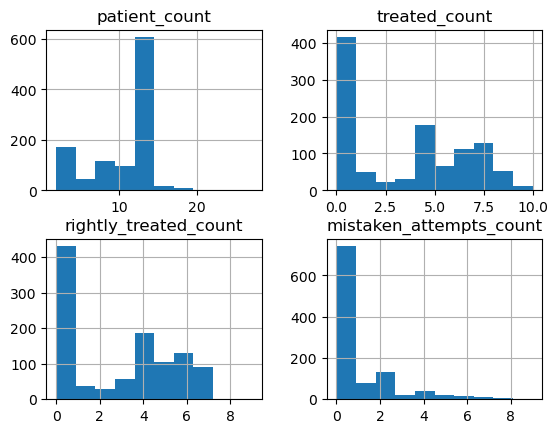

In [11]:

# Visualize histograms of all the distributions
columns_list = ['patient_count', 'treated_count', 'rightly_treated_count', 'mistaken_attempts_count']
rightly_treated_count_df[columns_list].hist();



## Did they do it in the right order?

(Red, Gray, Black), then wavers, then walkers last

In [12]:

# Investigate the presence of black
srs = frvrs_logs_df.applymap(lambda x: 'black' in str(x).lower(), na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
columns_list

['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']

In [13]:

# Investigate the presence of wave
srs = frvrs_logs_df.applymap(lambda x: 'wave' in str(x).lower(), na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
columns_list

['action_type', 'patient_demoted_sort', 'voice_capture_message', 'voice_command_message', 'voice_command_command_description', 'patient_record_sort', 's_a_l_t_wave_if_can_sort_command_text', 's_a_l_t_waved_sort_command_text', 'patient_engaged_sort']


#### Edge cases

The worst-case scenario is displayed as the blue vertical bar at the far left of the histogram. The best-case scenario is a component of the right-most vertical bar.

In [17]:

# Display a sample of adjusted R-squared at its maximum, dropping columns with all NaN values and transposing it
max_rsquared_adj = engagment_sort_df.rsquared_adj.max()
mask_series = engagment_sort_df.rsquared_adj.isin([max_rsquared_adj])
df = engagment_sort_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,277,522,785,402
logger_version,1.3,1.0,1.3,1.0
session_uuid,37ed31fb-6f8a-4cc0-b80e-ac4138e42405,741e494b-63ff-4ea2-ad88-657f2276045d,b5a82a5b-e259-4d87-bdb7-94f9cb1ce6ea,5dce5abe-7ded-46e7-8d07-b2e2cd76ef55
time_group,2,1,1,1
last_threat_engaged,1005491.0,271506.0,279352.0,143073.0
last_walker_engaged,1005491.0,272859.0,283207.0,157464.0
rsquared_adj,1.0,1.0,1.0,1.0
last_still_engaged,530803.0,89570.0,48755.0,58727.0
last_waver_engaged,778433.0,108946.0,124270.0,116633.0
stills_finished_first,True,True,True,True


In [18]:

# Display a sample of adjusted R-squared at its minimum, dropping columns with all NaN values and transposing it
min_rsquared_adj = engagment_sort_df.rsquared_adj.min()
mask_series = engagment_sort_df.rsquared_adj.isin([min_rsquared_adj])
df = engagment_sort_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,65
logger_version,1.0
session_uuid,0b891add-e0c3-463d-948d-7f491f1d10ef
time_group,4
last_threat_engaged,676501.0
last_walker_engaged,653151.0
rsquared_adj,-0.5
last_still_engaged,676501.0
last_waver_engaged,722393.0
stills_finished_first,False


In [19]:

# In the worse-case scenario, the trainee was supposed to engage the waver first, then the two walkers
# Instead, they engaged one of the walkers, then a waver, then the other walker
session_uuid = '274ce308-c366-4829-b9cc-d535b51d16d3'
time_group = 1
engaged_sort_dict = {'walker': [54614, 102065], 'waver': [88520]}
ideal_sequence = []
for sort in ['still', 'waver', 'walker']: ideal_sequence.extend(engaged_sort_dict.get(sort, []))
ideal_sequence = pd.Series(data=ideal_sequence)
actual_sequence = ideal_sequence.sort_values(ascending=True)
print(f'ideal_sequence = {ideal_sequence.tolist()}\nactual_sequence = {actual_sequence.tolist()}')
X, y = ideal_sequence.values.reshape(-1, 1), actual_sequence.values.reshape(-1, 1)
X1 = sm.add_constant(X)
try: rsquared_adj = sm.OLS(y, X1).fit().rsquared_adj
except: rsquared_adj = np.nan
print(f'rsquared_adj = {rsquared_adj}')

ideal_sequence = [88520, 54614, 102065]
actual_sequence = [54614, 88520, 102065]
rsquared_adj = -0.9971283921806686


In [20]:

# In the best-case scenario, the trainee was supposed to engage the still first, then the waver, then the walkers
# They executed this in the correct sequence
session_uuid = '7de52180-d823-4f9e-9003-aeab8139970b'
time_group = 1
engaged_sort_dict = {'still': [56434], 'walker': [164294, 195562, 208187, 210397, 211747, 212450, 212649], 'waver': [108854]}
ideal_sequence = []
for sort in ['still', 'waver', 'walker']: ideal_sequence.extend(engaged_sort_dict.get(sort, []))
ideal_sequence = pd.Series(data=ideal_sequence)
actual_sequence = ideal_sequence.sort_values(ascending=True)
print(f'ideal_sequence = {ideal_sequence.tolist()}\nactual_sequence = {actual_sequence.tolist()}')
X, y = ideal_sequence.values.reshape(-1, 1), actual_sequence.values.reshape(-1, 1)
X1 = sm.add_constant(X)
try: rsquared_adj = sm.OLS(y, X1).fit().rsquared_adj
except: rsquared_adj = np.nan
print(f'rsquared_adj = {rsquared_adj}')

ideal_sequence = [56434, 108854, 164294, 195562, 208187, 210397, 211747, 212450, 212649]
actual_sequence = [56434, 108854, 164294, 195562, 208187, 210397, 211747, 212450, 212649]
rsquared_adj = 1.0



### Stills Finished First

In [21]:

# Verify that the stills were finished first
import numpy as np

def f(df):
    last_still_engaged = df.last_still_engaged
    last_walker_engaged = df.last_walker_engaged
    last_waver_engaged = df.last_waver_engaged
    min_engagement = min(last_still_engaged, last_walker_engaged, last_waver_engaged)

    return (last_still_engaged == min_engagement)
engagment_sort_df['stills_finished_first'] = engagment_sort_df.apply(f, axis='columns')

# Create a mask where any of the last engaged columns are NaN and set the stills finished first column to NaN if true
columns_list = ['last_still_engaged', 'last_walker_engaged', 'last_waver_engaged']
mask_series = engagment_sort_df[columns_list].isnull().any(axis='columns')
engagment_sort_df.loc[mask_series, 'stills_finished_first'] = np.nan

mask_series = (engagment_sort_df.stills_finished_first == False)
df = engagment_sort_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,862,731,466,783
logger_version,1.0,1.0,1.0,1.3
session_uuid,cf953248-e6cf-4544-95ce-4843d0f56f10,ab1f8cd1-8d65-45da-b087-89b25ff46c66,693461dd-b8f6-4c60-92b6-bd1db0ffcac8,b541f5c9-93fe-4ef3-9fe7-38493b8aa8a8
time_group,2,1,1,2
last_threat_engaged,822747.0,748245.0,447319.0,712932.0
last_walker_engaged,770516.0,613587.0,392835.0,681491.0
rsquared_adj,0.516312,0.058678,0.180085,0.446786
last_still_engaged,822747.0,748245.0,447319.0,712932.0
last_waver_engaged,835218.0,735900.0,301317.0,570074.0
stills_finished_first,False,False,False,False


In [25]:

cn = 'voice_capture_message'
mask_series = frvrs_logs_df[cn].isnull()
# sorted([vc for vc in frvrs_logs_df[~mask_series][cn]], key=lambda x: len(x))[-10:]
srs = frvrs_logs_df[~mask_series][cn].value_counts()
mask_series = srs.index.map(lambda x: len(x) > 25)
srs[mask_series].head(10)

are you hurt anywhere else                     16
do you have any other injuries                 13
if you can hear me wave your hand               9
are you hurting anywhere else                   7
anybody that can wave wave                      6
have you heard anywhere else                    5
sir can you tell me your name                   5
if you can hear my voice I want you to wave     4
if you can hear my voice wave                   4
are you injured anywhere else                   4
Name: voice_capture_message, dtype: int64